# Working with Images & Logistic Regression in PyTorch

* PyTorch에서 이미지 작업(MNIST 데이터 세트 사용)
* 데이터 세트를 훈련, 검증 및 테스트 세트로 분할
* nn.Module 클래스를 확장하여 사용자 정의 로직으로 PyTorch 모델 생성
* Softmax를 사용하여 모델 출력을 확률로 해석하고 예측된 레이블 선택
* 분류 문제에 대한 유용한 평가 지표(정확도) 및 손실 함수(교차 엔트로피) 선택
* 검증 세트를 사용하여 모델을 평가하는 훈련 루프 설정
* 무작위로 선택한 예제에서 수동으로 모델 테스트
* 처음부터 다시 학습하지 않도록 모델 체크포인트 저장 및 로드

## Working with Images

이 파트에서는 PyTorch 및 선형 회귀(linear regression)에 대한 기존 지식을 사용하여 매우 다른 종류의 문제인 이미지 분류를 해결합니다. 우리는 훈련 데이터 세트로 유명한 MNIST 손으로 쓴 숫자 데이터베이스를 사용할 것입니다. 손으로 쓴 숫자(0~9)의 28픽셀 x 28픽셀 그레이스케일 이미지와 각 이미지가 나타내는 숫자를 나타내는 레이블로 구성됩니다. 다음은 데이터세트의 샘플 이미지입니다.

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

먼저 torch 와 torchvision을 (설치하고) 가져옵니다. torchvision 에는 이미지 데이터 작업을 위한 몇 가지 유틸리티가 포함되어 있습니다. 또한 MNIST와 같은 인기 있는 데이터 세트를 자동으로 다운로드하고 가져올 수 있는 도우미 클래스를 제공합니다.

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

dataset = MNIST(root='data/', download=False)

이 명령문이 처음 실행되면 노트북 옆의 data/ 디렉토리에 데이터를 다운로드하고 PyTorch Dataset을 생성합니다. 후속 실행에서는 데이터가 이미 다운로드 되었으므로 download=False로 바꿔 다운로드를 건너뜁니다. 데이터 세트의 크기를 확인합시다.

In [2]:
len(dataset)

60000

데이터 세트에는 모델을 훈련하는 데 사용할 60,000개의 이미지가 있습니다. 또한 모델을 평가하고 지표를 보고하는 데 사용되는 10,000개 이미지의 추가 테스트 세트가 있습니다. train=False를 생성자에 전달하여 MNIST 클래스를 사용하여 테스트 데이터 세트를 만들 수 있습니다.

In [3]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

훈련 dataset의 샘플 요소를 살펴보겠습니다.

In [4]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x171613FE8E0>, 5)

28x28 pixel 이미지와 레이블로 구성된 쌍입니다. 이미지는 파이썬 이미징 라이브러리 Pillow의 일부인 'PIL.Image.Image' 클래스의 객체입니다. Python의 데이터 과학을 위한 사실상의 플로팅 및 그래프 라이브러리인 matplotlib를 사용하여 Jupyter 내에서 이미지를 볼 수 있습니다.

label: 5


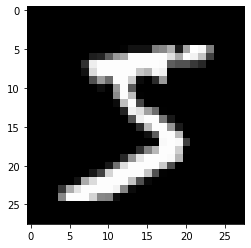

In [6]:
import matplotlib.pyplot as plt

image, label = dataset[0]
plt.imshow(image, cmap='gray')   # plt.axis('off')
print('label:', label)

label: 3


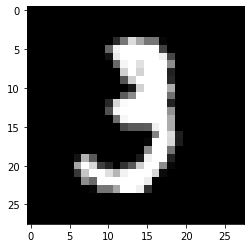

In [7]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')   #plt.axis('off')
print('label:', label)

이 이미지는 크기가 상대적으로 작으며 숫자를 인식하는 것은 사람의 눈으로도 때때로 어려울 수 있습니다. 이러한 이미지를 보는 것이 유용하지만 여기에는 한 가지 문제가 있습니다. PyTorch는 이미지로 작업하는 방법을 모릅니다. 이미지를 텐서로 변환해야 합니다. dataset 를 생성하는 동안 변환을 지정하여 이를 수행할 수 있습니다.

### 짤막한 지식

주피터 노트북에서 matplotlib의 imshow가 충돌하여 커널이 강제로 종료되는 경우 다음 해결법이 존재합니다.

* 방법 1 <br>
　　import os    
　　os.environ['KMP_DUPLICATE_LIB_OK']='True'

* 방법 2 <br>
　　윈도우에서 시스템 환경변수 추가 <br>
　　변수: KMP_DUPLICATE_LIB_OK <br>
　　값: TRUE

* 방법 3 <br>
　　conda install nomkl <br>
　　주의: 이 경우 다운로드가 불가능할 수도 있습니다.

----------------------------------------------------------------------------------------------------------------------------------------

In [8]:
import torchvision.transforms as transforms

PyTorch dataset를 사용하면 이미지가 로드될 때 이미지에 적용되는 하나 이상의 변환 함수를 지정할 수 있습니다. 'torchvision.transforms' 모듈에는 이러한 미리 정의된 함수들이 많이 포함되어 있습니다. 우리는 'ToTensor' 변환을 사용하여 이미지를 PyTorch 텐서로 변환합니다.

In [9]:
# MNIST dataset (imagse and labels)
dataset = MNIST(root='data/', 
                train=True, 
                transform=transforms.ToTensor())

In [10]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


이제 이미지가 1x28x28 텐서로 변환됩니다. 첫 번째 차원은 색상 채널에 해당합니다. 두 번째 및 세 번째 차원은 각각 이미지의 높이와 너비에 따른 픽셀을 나타냅니다. MNIST 데이터 세트의 이미지는 회색조이므로 채널이 하나만 있습니다. 다른 dataset 에는 색상이 있는 이미지가 있으며 이 경우 빨간색, 녹색 및 파란색(RGB)의 세 가지 채널이 있습니다.

텐서 내부의 몇 가지 샘플 값을 살펴보겠습니다.

In [11]:
print(img_tensor[0, 10:15, 10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


값의 범위는 0에서 1까지이며, '0'은 검은색, '1'은 흰색, 서로 다른 회색 음영 사이의 값입니다. plt.imshow를 사용하여 텐서를 이미지로 그릴 수도 있습니다.

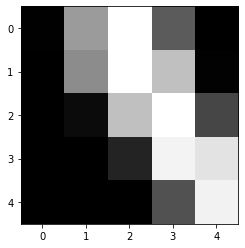

In [12]:
plt.imshow(img_tensor[0, 10:15, 10:15], cmap='gray')
plt.show()

채널 차원 없이 5x5 행렬만 plt.imshow에 전달해야 합니다. 또한 그레이스케일 이미지를 보고 싶다는 것을 나타내기 위해 컬러 맵(cmap=gray)을 전달합니다.

----------------------------------------------------------------------------------------------------------------------------------------

## Training and Validation Datasets

실제 기계 학습 모델을 구축하는 동안 데이터 세트를 세 부분으로 나누는 것이 일반적입니다.

1. 훈련(Training) 세트 - 모델을 훈련시키는 데 사용됩니다. 즉, 손실을 계산하고 경사하강법을 사용하여 모델의 가중치를 조정합니다.
2. 검증(Validation) 세트 - 훈련 중 모델을 평가하고, 하이퍼파라미터(학습률 등)를 조정하고, 모델의 최상의 버전을 선택하는 데 사용됩니다.
3. 테스트(Test) 세트 - 다양한 모델 또는 접근 방식을 비교하고 모델의 최종 정확도를 보고하는 데 사용됩니다.

MNIST 데이터셋에는 60,000개의 훈련 이미지와 10,000개의 테스트 이미지가 있습니다. 테스트 세트는 표준화되어 여러 연구자가 동일한 이미지 컬렉션에 대해 모델 결과를 보고할 수 있습니다.

사전 정의된 검증 세트가 없기 때문에 60,000개의 이미지를 훈련 및 검증 데이터 세트로 수동으로 분할해야 합니다. 유효성 검사를 위해 무작위로 선택한 10,000개의 이미지를 따로 보관해 보겠습니다. PyTorch의 'random_spilt' 메서드를 사용하여 이 작업을 수행할 수 있습니다.

In [13]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

검증 세트를 생성하기 위해 무작위 샘플을 선택하는 것은 필수적입니다. 훈련 데이터는 종종 대상 레이블, 즉 0, 1, 2 등의 이미지로 정렬됩니다. 이미지의 마지막 20%를 사용하여 검증 세트를 생성하면 8과 9로만 구성됩니다. 대조적으로 훈련 세트에는 8 또는 9가 포함되지 않습니다. 이러한 훈련 검증은 유용한 모델을 훈련하는 것을 불가능하게 만듭니다.

이제 데이터를 일괄적으로 로드하는 데 도움이 되는 데이터 로더를 만들 수 있습니다. 배치 크기 128을 사용합니다.

In [23]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

각 에포크에서 생성된 배치가 서로 다르게 하기 위해 훈련 데이터 로더에 대해 shuffle=True를 설정했습니다. 이 무작위화는 훈련 과정을 일반화하고 속도를 높이는 데 도움이 됩니다. 반면, validation 데이터 로더는 모델 평가에만 사용되기 때문에 이미지를 섞을 필요가 없습니다.

## Model

이제 data loader를 준비했으므로 모델을 정의할 수 있습니다.

* 로지스틱 회귀 모델은 선형 회귀 모델과 거의 동일합니다. 여기에는 가중치와 편향 행렬이 포함되어 있으며 간단한 행렬 연산(pred = x @ w.t() + b)을 사용하여 출력을 얻습니다.

* 선형 회귀에서 했던 것처럼 행렬을 수동으로 생성하고 초기화하는 대신 nn.Linear를 사용하여 모델을 생성할 수 있습니다.

* nn.Linear는 각 학습 예제가 벡터가 될 것으로 예상하므로 각 1x28x28 이미지 텐서는 모델에 전달되기 전에 크기 784 (28*28)의 벡터로 flattened 됩니다.

* 각 이미지의 출력은 크기가 10인 벡터이며, 각 요소는 특정 대상 레이블(즉, 0에서 9)의 확률을 나타냅니다. 이미지에 대해 예측된 레이블은 단순히 확률이 가장 높은 레이블입니다.

In [24]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

물론 이 모델은 매개변수의 수 면에서 이전 모델보다 훨씬 큽니다. 가중치와 편향에 대해 살펴보겠습니다.

In [25]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0059,  0.0199,  0.0219,  ..., -0.0304,  0.0045,  0.0357],
        [ 0.0181, -0.0044,  0.0218,  ..., -0.0178, -0.0148,  0.0028],
        [ 0.0298, -0.0122, -0.0230,  ..., -0.0218,  0.0295, -0.0141],
        ...,
        [ 0.0195, -0.0275,  0.0263,  ..., -0.0108, -0.0131,  0.0310],
        [ 0.0211, -0.0214, -0.0226,  ..., -0.0337, -0.0037,  0.0330],
        [-0.0154,  0.0132,  0.0344,  ...,  0.0244, -0.0326, -0.0207]],
       requires_grad=True)

In [26]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0175, -0.0334,  0.0056,  0.0111, -0.0352, -0.0181,  0.0083,  0.0344,
        -0.0287,  0.0265], requires_grad=True)

여기에는 총 7850개의 매개변수가 있지만 개념적으로는 지금까지 변경된 것이 없습니다. 모델을 사용하여 몇 가지 출력을 생성해 보겠습니다. 데이터 세트에서 첫 번째 배치를 가져와 모델에 전달합니다.

In [27]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([8, 2, 9, 8, 1, 3, 1, 7, 1, 4, 2, 4, 5, 1, 3, 2, 0, 7, 0, 9, 1, 7, 0, 4,
        1, 7, 1, 9, 7, 5, 5, 1, 0, 7, 1, 3, 7, 1, 9, 6, 6, 8, 8, 3, 1, 9, 1, 6,
        6, 2, 3, 5, 9, 8, 0, 6, 4, 9, 5, 3, 6, 2, 7, 7, 0, 9, 1, 9, 8, 9, 1, 8,
        0, 4, 8, 6, 8, 3, 5, 4, 8, 4, 6, 4, 9, 4, 6, 3, 1, 2, 0, 1, 1, 6, 1, 5,
        7, 3, 2, 9, 6, 1, 7, 8, 9, 1, 8, 8, 6, 7, 7, 6, 2, 2, 5, 2, 9, 3, 8, 1,
        7, 7, 7, 3, 8, 7, 8, 5])
torch.Size([128, 1, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 784x10)

In [28]:
images.shape

torch.Size([128, 1, 28, 28])

In [29]:
images.reshape(128, 784).shape

torch.Size([128, 784])

위의 코드는 입력 데이터의 모양이 맞지 않기 때문에 오류가 발생합니다. 우리의 이미지는 1x28x28 모양이지만, 이제는 크기가 784인 벡터가 필요합니다. 즉, flatten 해야 합니다. 우리는 텐서의 .reshape 메소드를 사용할 것입니다. 이를 통해 기본 데이터의 복사본을 실제로 생성하지 않고도 각 이미지를 flat 벡터로 효율적으로 '볼' 수 있습니다. 이 추가 기능을 모델에 포함하려면 PyTorch에서 nn.Module 클래스를 확장하여 사용자 정의 모델을 정의해야 합니다.

PyTorch에서 nn.Module 클래스를 확장하여 사용자 정의 모델을 정의해 보겠습니다.

In [30]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

__init__ 생성자 메서드 내에서 nn.Linear를 사용하여 가중치와 편향을 인스턴스화합니다. 그리고 모델에 일괄 입력을 전달할 때 호출되는 'forward' 메서드 내에서 입력 텐서를 flatten 하여 'self.linear'에 전달합니다.

xb.reshape(-1, 28*28)은 2차원의 xb 텐서의 보기를 원한다는 것을 PyTorch에 나타냅니다. 2차원의 길이는 28*28(즉, 784)입니다. .reshape에 대한 하나의 인수는 -1(이 경우 첫 번째 차원)으로 설정하여 PyTorch가 원래 텐서의 모양을 기반으로 자동으로 파악하도록 할 수 있습니다.

모델에는 더 이상 .weight 및 .bias 속성이 없지만(이제 .linear 속성 안에 있으므로) 가중치와 편향을 포함하는 목록을 반환하는 .parameters 메서드가 있습니다. .

In [31]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [32]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0174, -0.0272,  0.0232,  ..., -0.0180,  0.0002,  0.0193],
         [ 0.0140, -0.0036,  0.0187,  ...,  0.0183,  0.0095,  0.0026],
         [ 0.0211, -0.0112,  0.0319,  ..., -0.0288, -0.0302, -0.0312],
         ...,
         [-0.0003,  0.0113,  0.0148,  ..., -0.0064,  0.0346, -0.0012],
         [ 0.0146,  0.0300,  0.0328,  ..., -0.0195, -0.0151, -0.0184],
         [-0.0225,  0.0067, -0.0220,  ...,  0.0030,  0.0040, -0.0111]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0213, -0.0340, -0.0050,  0.0139, -0.0343, -0.0131,  0.0124, -0.0199,
         -0.0289, -0.0184], requires_grad=True)]

우리는 이전과 같은 방식으로 새로운 커스텀 모델을 사용할 수 있습니다. 작동하는지 봅시다.

In [33]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break
    
print(f'outputs.shape: {outputs.shape}')
print(f'sample outputs: \n {outputs[:2].data}')

torch.Size([128, 1, 28, 28])
outputs.shape: torch.Size([128, 10])
sample outputs: 
 tensor([[ 7.5499e-01,  2.4007e-01,  3.0717e-01, -4.8195e-02,  8.5344e-02,
          7.8629e-01, -4.4957e-01, -4.9742e-01, -1.4767e-01,  2.6465e-01],
        [ 6.7208e-01, -4.8393e-04,  3.7400e-01,  9.2943e-02,  4.4542e-01,
          5.3722e-01, -1.5625e-01, -7.7202e-01, -3.3545e-01,  2.2646e-02]])


100개의 입력 이미지 각각에 대해 각 클래스에 대해 하나씩 10개의 출력을 얻습니다. 앞서 논의한 바와 같이 우리는 이러한 출력이 확률을 나타내기를 원합니다. 각 출력 행의 요소는 0에서 1 사이에 있어야 하며 합이 1이 되어야 합니다.

출력 행을 확률로 변환하기 위해 다음 공식을 갖는 softmax 함수를 사용합니다.

![소프트맥스](https://i.imgur.com/EAh9jLN.png)

먼저 출력 행의 각 요소 yi를 e^yi로 교체하여 모든 요소를 양수로 만듭니다.

![](https://www.montereyinstitute.org/courses/DevelopmentalMath/COURSE_TEXT2_RESOURCE/U18_L1_T1_text_final_6_files/image001.png)

그런 다음 합이 1이 되도록 합으로 나눕니다. 따라서 결과 벡터는 확률로 해석될 수 있습니다.

softmax 함수를 구현하는 것은 쉽지만(시도해야 합니다!), 다차원 텐서(이 경우 출력 행 목록)와 잘 작동하는 PyTorch 내에서 제공되는 구현을 사용합니다.

In [34]:
import torch.nn.functional as F

softmax 함수는 torch.nn.functional 패키지에 포함되어 있으며 함수를 적용해야 하는 차원을 지정해야 합니다.

In [35]:
outputs[:2]

tensor([[ 7.5499e-01,  2.4007e-01,  3.0717e-01, -4.8195e-02,  8.5344e-02,
          7.8629e-01, -4.4957e-01, -4.9742e-01, -1.4767e-01,  2.6465e-01],
        [ 6.7208e-01, -4.8393e-04,  3.7400e-01,  9.2943e-02,  4.4542e-01,
          5.3722e-01, -1.5625e-01, -7.7202e-01, -3.3545e-01,  2.2646e-02]],
       grad_fn=<SliceBackward>)

In [36]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.1715, 0.1025, 0.1096, 0.0768, 0.0878, 0.1769, 0.0514, 0.0490, 0.0695,
         0.1050],
        [0.1654, 0.0844, 0.1228, 0.0927, 0.1319, 0.1446, 0.0723, 0.0390, 0.0604,
         0.0864]])
Sum:  1.0


마지막으로 각 출력 행에서 확률이 가장 높은 요소의 인덱스를 선택하기만 하면 각 이미지에 대한 예측 레이블을 결정할 수 있습니다. 각 행의 가장 큰 요소와 해당 인덱스를 반환하는 torch.max를 사용하여 이를 수행할 수 있습니다.

In [37]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([5, 0, 5, 5, 0, 4, 0, 5, 0, 5, 0, 0, 5, 5, 5, 5, 0, 5, 5, 0, 5, 0, 3, 3,
        0, 0, 0, 5, 0, 0, 2, 5, 0, 5, 5, 5, 5, 5, 0, 5, 5, 4, 5, 5, 5, 0, 5, 5,
        5, 0, 0, 5, 5, 8, 4, 0, 5, 0, 3, 4, 4, 5, 2, 5, 5, 5, 9, 4, 5, 5, 5, 5,
        5, 4, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 1, 4, 5, 4, 0, 5,
        5, 5, 4, 5, 5, 5, 0, 5, 5, 5, 4, 5, 2, 5, 0, 5, 0, 5, 5, 4, 4, 0, 0, 0,
        0, 5, 5, 0, 5, 5, 5, 5])
tensor([0.1769, 0.1654, 0.1371, 0.1516, 0.1454, 0.1516, 0.1470, 0.1471, 0.1207,
        0.1273, 0.1246, 0.1363, 0.1578, 0.1303, 0.1315, 0.1339, 0.1266, 0.1374,
        0.1720, 0.1465, 0.1339, 0.1570, 0.1263, 0.1319, 0.1851, 0.1624, 0.1698,
        0.1523, 0.1344, 0.1426, 0.1323, 0.1276, 0.1522, 0.1175, 0.1324, 0.1412,
        0.1391, 0.1718, 0.1394, 0.1351, 0.1578, 0.1483, 0.1380, 0.1122, 0.1306,
        0.1394, 0.1521, 0.1325, 0.1631, 0.1269, 0.1223, 0.1405, 0.1615, 0.1274,
        0.1443, 0.1266, 0.1501, 0.1431, 0.1143, 0.1268, 0.1354, 0.1349, 0.1283,
       

위에 인쇄된 숫자는 훈련 이미지의 첫 번째 배치에 대한 예측된 레이블입니다. 실제 라벨과 비교해 보겠습니다.

In [38]:
labels

tensor([2, 0, 0, 5, 3, 9, 2, 1, 4, 7, 6, 0, 5, 9, 6, 1, 0, 3, 3, 3, 4, 0, 7, 4,
        2, 0, 2, 0, 2, 4, 6, 9, 0, 6, 9, 8, 1, 8, 4, 5, 0, 7, 8, 4, 2, 4, 8, 5,
        3, 6, 7, 5, 3, 9, 4, 0, 8, 4, 9, 7, 4, 8, 5, 8, 8, 6, 2, 0, 8, 8, 6, 4,
        5, 7, 8, 8, 8, 1, 6, 6, 3, 4, 5, 6, 3, 1, 7, 8, 7, 4, 5, 9, 5, 9, 2, 6,
        4, 9, 6, 4, 0, 8, 1, 0, 8, 3, 9, 6, 6, 1, 5, 9, 5, 1, 5, 9, 7, 3, 4, 5,
        4, 1, 4, 5, 0, 6, 0, 1])

대부분의 예측된 레이블은 실제 레이블과 다릅니다. 무작위로 초기화된 가중치와 편향으로 시작했기 때문입니다. 모델을 훈련시켜야 합니다. 즉, 더 나은 예측을 위해 경사 하강법을 사용하여 가중치를 조정해야 합니다.

----------------------------------------------------------------------------------------------------------------------------------------

## Evaluation Metric and Loss Function

선형 회귀와 마찬가지로 모델이 얼마나 잘 수행되는지 평가할 방법이 필요합니다. 이를 수행하는 자연스러운 방법은 올바르게 예측된 레이블의 백분율을 찾는 것입니다. 예측의 정확도(accuracy).

In [39]:
outputs[:2]

tensor([[ 7.5499e-01,  2.4007e-01,  3.0717e-01, -4.8195e-02,  8.5344e-02,
          7.8629e-01, -4.4957e-01, -4.9742e-01, -1.4767e-01,  2.6465e-01],
        [ 6.7208e-01, -4.8393e-04,  3.7400e-01,  9.2943e-02,  4.4542e-01,
          5.3722e-01, -1.5625e-01, -7.7202e-01, -3.3545e-01,  2.2646e-02]],
       grad_fn=<SliceBackward>)

In [40]:
torch.sum(preds == labels)

tensor(18)

In [41]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

== 연산자는 모양이 같은 두 텐서의 요소별 비교를 수행하고 같지 않은 요소에 대해 'False'를 포함하고 동일한 요소에 대해 'True'를 포함하는 동일한 모양의 텐서를 반환합니다. 결과를 'torch.sum'에 전달하면 올바르게 예측된 레이블 수를 반환합니다. 마지막으로 정확도를 얻기 위해 총 이미지 수로 나눕니다.

결과가 동일한 상대 순서를 가지므로 출력에 softmax를 적용할 필요가 없습니다. 이것은 e^x가 증가하는 함수이기 때문입니다. 즉, y1 > y2이면 e^y1 > e^y2입니다. softmax를 얻기 위해 값을 평균화한 후에도 마찬가지입니다.

데이터의 첫 번째 배치에서 현재 모델의 정확도를 계산해 보겠습니다.

In [42]:
accuracy(outputs, labels)

tensor(0.1406)

In [43]:
probs

tensor([[0.1715, 0.1025, 0.1096,  ..., 0.0490, 0.0695, 0.1050],
        [0.1654, 0.0844, 0.1228,  ..., 0.0390, 0.0604, 0.0864],
        [0.1169, 0.0785, 0.1031,  ..., 0.0745, 0.0816, 0.1040],
        ...,
        [0.1132, 0.0936, 0.1044,  ..., 0.0792, 0.0825, 0.1027],
        [0.0884, 0.0848, 0.1053,  ..., 0.0769, 0.0960, 0.1065],
        [0.1112, 0.1108, 0.0980,  ..., 0.0889, 0.0976, 0.0912]],
       grad_fn=<SoftmaxBackward>)

정확도는 우리(인간)가 모델을 평가하는 훌륭한 방법입니다. 그러나 다음과 같은 이유로 경사하강법을 사용하여 모델을 최적화하기 위한 손실 함수로 사용할 수 없습니다.

1. 미분이 가능하지 않습니다. torch.max와 ==는 모두 비연속적이며 미분할 수 없는 연산이므로 가중치와 편향으로 기울기를 계산하는 데 정확도를 사용할 수 없습니다.

2. 모델에서 예측한 실제 확률을 고려하지 않으므로 점진적 개선에 대한 충분한 피드백을 제공할 수 없습니다.

이러한 이유로 정확도는 종종 분류를 위한 평가 메트릭(evaluation metric) 으로 사용되지만 손실 함수로는 사용되지 않습니다. 분류 문제에 일반적으로 사용되는 손실 함수는 교차 엔트로피(cross-entropy)이며 다음 공식을 사용합니다.

![크로스 엔트로피](https://i.imgur.com/VDRDl1D.png)

복잡해 보이지만 실제로는 매우 간단합니다.

각 출력 행에 대해 올바른 레이블에 대한 예측 확률을 선택합니다. 위의 그림에서, 이미지에 대한 예측 확률이 '[0.1, 0.5, 0.4]'이고 올바른 레이블이 '1'이면 해당 요소 '0.5'을 선택하고 나머지는 무시합니다.

그런 다음 선택한 확률의 logarithm을 취합니다. 확률이 높으면, 즉 1에 가까우면 그 로그는 0에 가까운 매우 작은 음수 값입니다. 그리고 확률이 낮으면(0에 가까움) 로그는 매우 큰 음수 값입니다. 또한 결과에 -1을 곱합니다. 이는 결과가 좋지 않은 예측에 대한 손실의 큰 양수 값입니다.

![](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

마지막으로 모든 출력 행에 대한 교차 엔트로피의 평균을 취하여 데이터 배치에 대한 전체 손실을 얻습니다.

정확도와 달리 교차 엔트로피는 연속적이고 미분 가능한 함수입니다. 또한 모델의 점진적 개선에 대한 유용한 피드백을 제공합니다(정확한 레이블에 대한 약간 더 높은 확률은 더 낮은 손실로 이어짐). 이 두 가지 요소는 교차 엔트로피를 손실 함수에 더 나은 선택으로 만듭니다.

예상할 수 있듯이 PyTorch는 torch.nn.functional 패키지의 일부로 효율적이고 텐서 친화적인 cross-entropy 구현을 제공합니다. 또한 내부적으로 softmax를 수행하므로 확률로 변환하지 않고 모델의 출력을 직접 전달할 수 있습니다.

In [44]:
outputs

tensor([[ 7.5499e-01,  2.4007e-01,  3.0717e-01,  ..., -4.9742e-01,
         -1.4767e-01,  2.6465e-01],
        [ 6.7208e-01, -4.8393e-04,  3.7400e-01,  ..., -7.7202e-01,
         -3.3545e-01,  2.2646e-02],
        [ 3.2241e-01, -7.6278e-02,  1.9631e-01,  ..., -1.2818e-01,
         -3.7615e-02,  2.0562e-01],
        ...,
        [ 1.9773e-01,  8.0306e-03,  1.1750e-01,  ..., -1.5883e-01,
         -1.1808e-01,  1.0046e-01],
        [-3.4999e-02, -7.6971e-02,  1.4011e-01,  ..., -1.7402e-01,
          4.7888e-02,  1.5116e-01],
        [ 8.6415e-02,  8.3145e-02, -3.9704e-02,  ..., -1.3699e-01,
         -4.4149e-02, -1.1149e-01]], grad_fn=<AddmmBackward>)

In [45]:
loss_fn = F.cross_entropy

In [46]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.2864, grad_fn=<NllLossBackward>)


우리는 cross-entropy 가 모든 훈련 샘플에 대해 평균화된 올바른 레이블의 예측 확률의 음의 로그라는 것을 알고 있습니다. 따라서 결과 숫자를 해석하는 한 가지 방법은 다음과 같습니다. 

결과값 2.28은 올바른 레이블의 예측 확률로써 e^-2.28, 즉 0.1 정도입니다. 손실이 낮을수록 좋은 모델입니다.

----------------------------------------------------------------------------------------------------------------------------------------

## Training the model

이제 데이터 로더, 모델, 손실 함수 및 옵티마이저를 정의했으므로 모델을 훈련할 준비가 되었습니다. 훈련 과정은 각 시대의 모델을 평가하기 위해 "검증 단계"가 추가된 선형 회귀와 동일합니다. pseudocode는 다음과 같습니다.

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

훈련 루프의 일부는 우리가 해결하고 있는 특정 문제(예: 손실 함수, 메트릭 등)에 특정한 반면 다른 부분은 일반적이며 모든 딥러닝 문제에 적용할 수 있습니다.

모델을 훈련하는 데 사용되는 'fit'이라는 함수에 문제와 무관한 부분을 포함할 것입니다. 문제별 부분은 `nn.Module` 클래스에 새 메서드를 추가하여 구현됩니다.

In [55]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

'fit' 함수는 각 에포크의 유효성 검사 손실과 메트릭을 기록합니다. 디버깅 및 시각화에 유용한 교육 기록을 반환합니다.

배치 크기, 학습률 등과 같은 구성(초매개변수라고 함)은 기계 학습 모델을 학습하는 동안 미리 선택해야 합니다. 적절한 초매개변수를 선택하는 것은 합리적인 시간 내에 합리적으로 정확한 모델을 훈련하는 데 중요합니다. 기계 학습에서 연구 및 실험이 활발한 영역입니다. 자유롭게 다양한 학습률을 시도하고 학습 과정에 어떤 영향을 미치는지 확인하십시오.

'fit'의 검증 단계에서 사용되는 'evaluate' 함수를 정의해 봅시다.

In [56]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

마지막으로 fit과 evaluate에서 사용하는 training_step, validation_step, validation_epoch_end, epoch_end를 추가로 포함하도록 MnistModel 클래스를 재정의해 보겠습니다.

In [57]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

모델을 훈련하기 전에 무작위로 초기화된 가중치 및 편향의 초기 세트를 사용하여 검증 세트에서 모델이 어떻게 수행되는지 봅시다.

In [58]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.329630136489868, 'val_acc': 0.05448971688747406}

초기 정확도는 약 10%이며 무작위로 초기화된 모델에서 기대할 수 있습니다(무작위로 추측하여 올바른 레이블을 얻을 확률이 10분의 1이기 때문에).

이제 모델을 훈련할 준비가 되었습니다. 5개의 Epoch 동안 훈련하고 결과를 살펴보겠습니다.

In [59]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9635, val_acc: 0.5978
Epoch [1], val_loss: 1.6918, val_acc: 0.7204
Epoch [2], val_loss: 1.4888, val_acc: 0.7571
Epoch [3], val_loss: 1.3355, val_acc: 0.7775
Epoch [4], val_loss: 1.2175, val_acc: 0.7909


좋은 결과입니다! 단 5개의 Epoch 훈련으로 우리 모델은 검증 세트에서 80% 이상의 정확도에 도달했습니다. 몇 에포크(epoch)에 대한 훈련을 더 개선할 수 있는지 봅시다. 아래의 각 셀에서 학습률과 Epoch 수를 변경해 보십시오.

In [60]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1247, val_acc: 0.8030
Epoch [1], val_loss: 1.0502, val_acc: 0.8104
Epoch [2], val_loss: 0.9893, val_acc: 0.8147
Epoch [3], val_loss: 0.9385, val_acc: 0.8204
Epoch [4], val_loss: 0.8956, val_acc: 0.8248


In [61]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8589, val_acc: 0.8287
Epoch [1], val_loss: 0.8270, val_acc: 0.8316
Epoch [2], val_loss: 0.7991, val_acc: 0.8333
Epoch [3], val_loss: 0.7745, val_acc: 0.8357
Epoch [4], val_loss: 0.7526, val_acc: 0.8381


In [62]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7329, val_acc: 0.8411
Epoch [1], val_loss: 0.7151, val_acc: 0.8434
Epoch [2], val_loss: 0.6990, val_acc: 0.8450
Epoch [3], val_loss: 0.6843, val_acc: 0.8470
Epoch [4], val_loss: 0.6708, val_acc: 0.8490


더 많은 Epoch에 대해 학습함에 따라 정확도는 계속 증가하지만 개선은 모든 Epoch에 따라 작아집니다. 이것을 선 그래프를 사용하여 시각화해 보겠습니다.

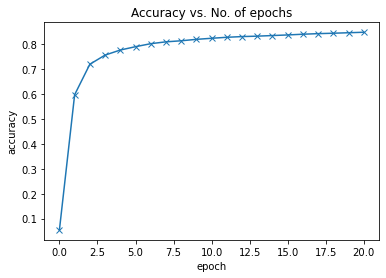

In [63]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

위의 그림을 보면 아주 오랜 시간 동안 훈련을 시켜도 모델이 정확도 임계값 90%를 넘지 않을 것이라는 점을 아주 분명하게 알 수 있습니다. 이에 대한 한 가지 가능한 이유는 학습률이 너무 높을 수 있기 때문입니다. 모델의 매개변수는 가장 낮은 손실을 위한 최적의 매개변수 세트를 중심으로 "바운스"할 수 있습니다. 학습 속도를 줄이고 몇 에포크를 더 훈련하여 도움이 되는지 확인할 수 있습니다.

모델이 충분히 강력하지 않은 이유가 더 많습니다. 우리는 출력(이 경우 클래스 확률)이 가중치 행렬로 행렬 곱셈을 수행하고 편향을 추가하여 얻은 입력(픽셀 강도)의 선형 함수라고 가정했습니다. 이것은 이미지의 픽셀 강도와 이미지가 나타내는 숫자 사이에 선형 관계가 실제로 존재하지 않을 수 있으므로 이것은 상당히 약한 가정입니다. MNIST와 같은 간단한 데이터 세트에서는 합리적으로 잘 작동하지만(85% 정확도 제공), 일상적인 물체, 동물 등을 인식하는 것과 같은 복잡한 작업을 위해 이미지 픽셀과 레이블 간의 비선형 관계를 캡처할 수 있는 보다 정교한 모델이 필요합니다.

----------------------------------------------------------------------------------------------------------------------------------------

## Testing with individual images

지금까지 모델의 전체 정확도를 추적했지만 일부 샘플 이미지에서 모델의 결과를 살펴보는 것도 좋은 생각입니다. 미리 정의된 10000개 이미지의 테스트 데이터 세트에서 일부 이미지로 모델을 테스트해 보겠습니다. 먼저 'ToTensor' 변환으로 테스트 데이터 세트를 다시 생성합니다.

In [64]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

다음은 데이터세트의 샘플 이미지입니다.

Shape: torch.Size([1, 28, 28])
Label: 7


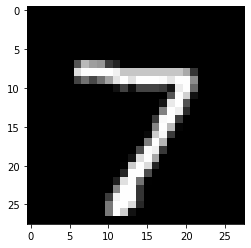

In [65]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

단일 이미지 텐서에 대해 예측된 레이블을 반환하는 도우미 함수 predict_image를 정의해 보겠습니다.

In [66]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

img.unsqueeze는 1x28x28 텐서의 시작 부분에 다른 차원을 추가하여 1x1x28x28 텐서로 만들고 모델이 단일 이미지를 포함하는 배치로 봅니다.

몇 가지 이미지로 시도해 보겠습니다.

Label: 7 , Predicted: 7


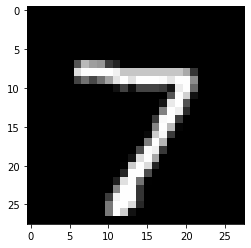

In [67]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


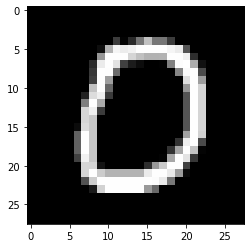

In [68]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


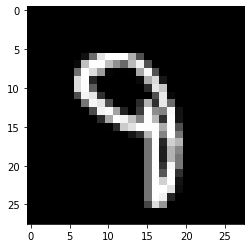

In [69]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


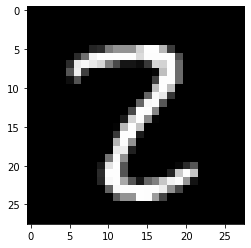

In [70]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

모델 성능이 저조한 위치를 식별하면 더 많은 훈련 데이터를 수집하고 모델의 복잡성을 증가/감소시키고 하이퍼파라미터를 변경하여 모델을 개선하는 데 도움이 될 수 있습니다.

마지막 단계로 테스트 세트에서 모델의 전체 손실과 정확도도 살펴보겠습니다.

In [71]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6435350179672241, 'val_acc': 0.859375}

우리는 이것이 검증 세트의 정확도/손실과 유사할 것으로 예상합니다. 그렇지 않은 경우 테스트 세트와 유사한 데이터 및 분포를 가진 더 나은 검증 세트가 필요할 수 있습니다(종종 실제 데이터에서 가져옴).

----------------------------------------------------------------------------------------------------------------------------------------

## Saving and loading the model

우리는 오랜 시간 동안 모델을 훈련했고 상당한 정확도를 달성했기 때문에 나중에 모델을 재사용하고 처음부터 다시 훈련하지 않도록 가중치와 편향 행렬을 디스크에 저장하는 것이 좋습니다. 모델을 저장하는 방법은 다음과 같습니다.

In [72]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [73]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0229, -0.0214,  0.0087,  ..., -0.0293,  0.0171,  0.0110],
                      [ 0.0095, -0.0292, -0.0240,  ..., -0.0354,  0.0327, -0.0101],
                      [-0.0136,  0.0133,  0.0085,  ...,  0.0347, -0.0174,  0.0213],
                      ...,
                      [ 0.0287, -0.0119, -0.0014,  ...,  0.0207,  0.0164, -0.0072],
                      [ 0.0152,  0.0131,  0.0351,  ..., -0.0329, -0.0220, -0.0044],
                      [-0.0035, -0.0262, -0.0004,  ..., -0.0115, -0.0193,  0.0095]])),
             ('linear.bias',
              tensor([-0.0571,  0.0816, -0.0078, -0.0464,  0.0073,  0.0774, -0.0338,  0.0699,
                      -0.0943, -0.0400]))])

모델 가중치를 로드하기 위해 MnistModel 클래스의 새 객체를 인스턴스화하고 .load_state_dict 메소드를 사용할 수 있습니다.

In [74]:
model2 = MnistModel()

In [75]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0002,  0.0211,  0.0090,  ..., -0.0048, -0.0349,  0.0164],
                      [-0.0039,  0.0321,  0.0019,  ...,  0.0340,  0.0330, -0.0120],
                      [-0.0312,  0.0311, -0.0155,  ...,  0.0196, -0.0301, -0.0263],
                      ...,
                      [-0.0209, -0.0340, -0.0046,  ..., -0.0177, -0.0196, -0.0239],
                      [-0.0076, -0.0245,  0.0063,  ..., -0.0175, -0.0002,  0.0212],
                      [-0.0127,  0.0348,  0.0098,  ...,  0.0052,  0.0341,  0.0087]])),
             ('linear.bias',
              tensor([-0.0187, -0.0051,  0.0150,  0.0187, -0.0229, -0.0166,  0.0228,  0.0142,
                       0.0265,  0.0079]))])

In [76]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 2.3253676891326904, 'val_acc': 0.14248046278953552}

In [77]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0229, -0.0214,  0.0087,  ..., -0.0293,  0.0171,  0.0110],
                      [ 0.0095, -0.0292, -0.0240,  ..., -0.0354,  0.0327, -0.0101],
                      [-0.0136,  0.0133,  0.0085,  ...,  0.0347, -0.0174,  0.0213],
                      ...,
                      [ 0.0287, -0.0119, -0.0014,  ...,  0.0207,  0.0164, -0.0072],
                      [ 0.0152,  0.0131,  0.0351,  ..., -0.0329, -0.0220, -0.0044],
                      [-0.0035, -0.0262, -0.0004,  ..., -0.0115, -0.0193,  0.0095]])),
             ('linear.bias',
              tensor([-0.0571,  0.0816, -0.0078, -0.0464,  0.0073,  0.0774, -0.0338,  0.0699,
                      -0.0943, -0.0400]))])

In [78]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.6435350179672241, 'val_acc': 0.859375}

----------------------------------------------------------------------------------------------------------------------------------------

## Exercises

지금까지 배운 개념과 기술을 적용하기 위해 다음 문제를 가지고 연습해 보세요:

* End-to-end 모델 코딩을 위한 연습 노트: https://jovian.ai/aakashns/02-insurance-linear-regression
* 로지스틱 회귀 분석 프로젝트를 위한 시작 노트: https://jovian.ai/aakashns/mnist-logistic-minimal
* 선형 회귀 프로젝트를 위한 시작 노트: https://jovian.ai/aakashns/housing-linear-minimal

짧은 시간 내에 훌륭한 기계 학습 모델을 훈련하려면 연습과 경험이 필요합니다. 다양한 데이터 세트, 모델 및 하이퍼 파라미터로 실험해 보십시오. 이 기술을 습득하는 가장 좋은 방법입니다.